<h1><center> Improvement of Nonprofits Direct Mailing Campaigns by using Machine Learning Algorithms <h1><center>


    
**Author : Lucas Policarpo**



**This project was used as the final assignment of the Machine Learning course at the University of Toronto. The data belongs to one of the most relevant charities in Canada and its use authorized for the purpose of this work.**

# Summary



Nonprofits and charities depend on support and funds from donors and well-wishers to keep their organization running. Direct mail advertising, although relatively costly, provides a reliable way to engage donors and increase their giving. Therefore, designing targeted mailing lists is a very important goal for these institutions. 

This project proposes using a Machine Learning approach to design mailing lists by determining the probability of a donor responding to an upcoming appeal. To achieve this a Donor Profile was engineered from a transaction database and its features used as inputs for statistical models. Models tested were: Logistic Regression, Random Forest Classifier and Support Vector Classifier. 

The results show that Machine Learning has a great potential to be applied in fundraising. The  Support Vector Classifier model was able to roughly double the response rate of lists from 3.61% to  6.98% and increase revenues by 22% when compared to the current process of selecting donors. 


# 1. Introduction

## 1.1 Objective


1. Predict responsive donors to increase profit and response rate of direct mailing campaigns. 
2. Reduce costs of unnecessary mails.
3. Improve relationship with contributors. Reduce donor fatigue by making fewer and more targeted solicitations.


## 1.2 Current Scenario 


The current ongoing process is based on a single rule:  Send mail to all donors who have donated to the organization over the last 5 years. This is done several times during the year. Although still profitable most of the times, the current response rate ranges around 3.5 to 5% for successful campaigns. Therefore, a significant sum of money is lost from unresponsive givers as the production added to mailing cost varies around $2 per unit. Moreover, often people complain about the high number of appeals they receive.

## 1.3 Proposed Scenario


Send mail solicitations only to people that are more likely to respond to an upcoming appeal by using a Machine Learning model as a predictor. Smaller direct mail lists are expected.

## 1.4 Method


The model will be designed to calculate the probability of a donor to respond to an upcoming mail appeal. Hence, solve a classification problem. To achieve this, donations data containing both unsolicited and solicited gifts from 2005 to 2020 will be used to create a new and improved donor profile. Its features then used as inputs to train a model. Past direct mail lists data will be used to build labels so a supervised learning approach can be used.


The figure below illustrates how the whole process of predicting responsive donors work.

<img src="pic1.PNG">

It is important to mention that three past mailing lists were used to train the model, and for each of these lists a different donor profile timeframe was used. For example, List 1 Appeal was launched on Mar/15/2019, therefore the donor profile must have data only up to Mar/14/2019, so no future information is used in prediction.
    
    
    List 1 : Donor history from Jan/01/2005 to Mar/14/2019
    List 2 : Donor history from Jan/01/2005 to Oct/10/2019
    List 3 : Donor history from Jan/01/2005 to Dec/10/2019


Althought the Feature Engineering process produced a high number of variables, one can see that these features were built only using the past giving information from donors. Unfortunately, most charities have no additional information about their donors, making the prediction challenge more difficult.  



Important information that could be added to the model include if were available :

- Age
- Gender
- Family size
- Educational level
- Household income (could be an estimate)
- Occupation
- Motivation
- Interaction with donors
    

# 2. Donor Profile Design

<font color='darkblue'>
This section contains all the codes and explanation to build the donor profile. Some of the variables are used for exploratory data analysis purposes and not as inputs for the model.

In [1]:
# Importing packages

import pandas as pd
import numpy as np
import seaborn as sns   
sns.set(style="whitegrid") 
sns.set_context("paper",font_scale=1.5, rc = {'lines.linewidth': 1.2, 'lines.markersize': 10})
sns.set_style("ticks")

import datetime as dt
from datetime import datetime
import os

from pandas import ExcelWriter

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)


from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2,f_classif, f_regression, mutual_info_classif
from sklearn.metrics import precision_recall_curve,roc_curve, accuracy_score,make_scorer
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.feature_selection import SelectKBest, chi2,f_regression,f_classif,RFE
import pickle


In [2]:
import sklearn
sklearn.__version__

'0.20.3'

## 2.1 Donor Profile functions

<font color='darkblue'>

The following functions were built:

 - filters -> Selects the desired subset of gifts. Select timeframe and removes unwanted designations, payment methods and organization donations.  


 - fix_GWV_gifts -> Responsible for fixing GWV designation type of gifts. This category of donations requires additional aggregation before moving to the next step.  
 
 
 - current_status -> Determines if a donor is currently active.  
 
 

 - post_code_info -> Determines the province of the donor and if it is a rural or urban area from the Postal Code.  



 - donor_aggregation -> First step of gifts aggregation by Donor ID. Example: Calculates total donated by donor.   



 - donor_dataset -> Creates new features based on the first aggregation. Example: Days since first and last donation, cash flow by year, donor segment, etc.  



 - designations_donor_dataset -> Breaks down all the features created above by each of the three designations categories (MS, GWV, ERSG). Example it calculates the total donated to MS, GWV and ERSG by each Donor ID.  
 

 
 - campaign_analysis-> Filters the donors which belongs to the direct mailing list and determines whether they reponded or not in a given timeframe.
 
 

In [13]:
def filters(df, end_date , initial_date):
    
    initial_date = dt.datetime.strptime(initial_date, '%Y-%m-%d')
    end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')

    filter1 = (df['Document_Date'] >= initial_date) & (df['Document_Date'] <= end_date)
    filter2 = df['Payment_Amount'] > 0
    filter3 = df['Payment_Type'].isin(['CHEQUE','CASH','MC','E-DON','E-DON VISA','E-DON MC','E-DON AMEX','VISA','OTHER','VISA','PAR','PAYROLL','ACCTPAY'])
    filter4 = ~df['Donor'].str.contains('Estate')
    filter5 = ~df['Salutation'].fillna("").str.contains('Estate')
    filter6 = ~df['Gift_Category'].isnull()
    filter7 = df['Donor_Type'] == 'Individual'
    filter8 = df['Payment_Amount'] <= 10000

    return df[filter1 & filter2 & filter3 & filter4 & filter5 & filter6 & filter7 & filter8 ].reset_index(drop = True)

In [14]:
# Fix GWV gifts

def fix_GWV_gifts(df):
    
    filter1 = df['Gift_Category'].str.contains('GWV')

    df_GWV = df[filter1]
    df = df[~filter1]

    # Aggregating GWV purchases into only one gift
    df_GWV['Payment_Amount'] = df_GWV.groupby(['Donor_ID','Document_Date'])['Payment_Amount'].transform('sum')
    df_GWV.sort_values('Donor_ID', inplace=True)
    df_GWV.drop_duplicates(['Donor_ID','Document_Date'], keep ='first', inplace = True)

    return pd.concat([df,df_GWV], axis =0).reset_index(drop=True)

In [15]:
# Function determining the criterion of a custumer being current active
def current_status(row, current_year, previous_year):
      
    if (row[current_year] != 0) or (row[previous_year] != 0):     
        return 1
    
    else:        
        return 0

In [16]:
def post_code_info (row):
    
    province  = ""
    area = ""
    code = str(row).replace(" ", "")
    
    if code[1] == '0' :
        area = 0
        
    else:
        area = 1
    
    if code[0] == 'T':
        province = 'AB'
        
    elif code[0] == 'V':
        province = 'BC'
        
    elif code[0] == 'R':
        province = 'MB'
        
    elif code[0] == 'E':
        province = 'NB'
        
    elif code[0] == 'A':
        province = 'NL'
        
    elif code[0] == 'B':
        province = 'NS'
        
    elif code[0] == 'X':
        province = 'NT/NU'
        
    elif code[0] in ['K','L', 'M','N','P']:
        province = 'ON'
        
    elif code[0] in ['G','H', 'J','K']:
        province = 'QC'
        
    elif code[0] == 'S':
        province = 'SK'
        
    elif code[0] == 'Y':
        province = 'YT'
        
    elif code[0] == 'C':
        province = 'PE'
        
 
    return area,province

In [17]:
def donor_aggregation (df):
    
    filter1 = df['Payment_Type'].str.contains('E-DON')
    appeals_list = ['DGA15','DGA16','DGA17','DGA18','DG18-AMS','DG18-AER', 'DG18-AOB', 'DG18-AGWV','DG19-EER', 'DG19-EMS', 'DG19-EGWV','DG19-AOB','DG19-TMS','DG19-ABG']
    
    df = df.sort_values(['Donor_ID','Document_Date'], ascending = True)
    
    return {
        
           'first_gift_date':df['Document_Date'].iloc[0], 'last_gift_date': df['Document_Date'].iloc[-1], 'first_gift_amount':df['Payment_Amount'].iloc[0],
           'last_gift_amount':df['Payment_Amount'].iloc[-1], 'total_donated':df['Payment_Amount'].sum(), 'donation_count':df['Payment_Amount'].count(),
           'std_donated':df['Payment_Amount'].std(), 'average_donated': df['Payment_Amount'].mean(),'median_donated': df['Payment_Amount'].median(), 'max_donated': df['Payment_Amount'].max(),
           'ave_donation_gap':np.mean((df['Document_Date'] - df['Document_Date'].shift(1)).dt.days), 'min_donation_gap':np.min((df['Document_Date'] - df['Document_Date'].shift(1)).dt.days),
           'max_donation_gap':np.max((df['Document_Date'] - df['Document_Date'].shift(1)).dt.days), 'total_donated_ON': df[filter1]['Payment_Amount'].sum(), 
           'donation_count_ON': df[filter1]['Payment_Amount'].count(), 'appeal_count': df['Appeal'].isin(appeals_list).sum()
    
    }

In [18]:
def donor_dataset (df, end_date , initial_date, suffix =""):
        
    df = filters(df, end_date , initial_date)
    df = fix_GWV_gifts(df)
        
    X = df.groupby('Donor_ID').apply(donor_aggregation)
    df_donor = pd.DataFrame(list(X), index = X.index).reset_index()
    
    # Removing Nan values from columns
    df_donor['ave_donation_gap'].fillna(0, inplace = True)
    df_donor['max_donation_gap'].fillna(0, inplace = True)
    df_donor['min_donation_gap'].fillna(0, inplace = True)
    
    # New columns
    df_donor['first_gift_year'] = df_donor['first_gift_date'].dt.year
    df_donor['last_gift_year'] = df_donor['last_gift_date'].dt.year
    df_donor['lifespan_total'] = (df_donor['last_gift_date'] - df_donor['first_gift_date']).dt.days
    df_donor['one_timer'] = df_donor['donation_count'].apply(lambda x: 1 if x == 1 else 0)
    df_donor['major_donor'] = df_donor['max_donated'].apply(lambda x: 1 if x >= 1000 else 0)
    df_donor['donation_segment_ave'] = pd.cut(df_donor['average_donated'], bins = [0,25,50,100,1000,10000,100000000], 
                                            right = True, labels = ['1-25 CAD','26-50 CAD','51-100 CAD','101-1000 CAD','1000-10000 CAD','over 10000 CAD'])
    df_donor['donation_rate'] = df_donor['lifespan_total']/df_donor['donation_count']
    df_donor['days_sld'] = (dt.datetime.strptime(end_date, '%Y-%m-%d').date() - df_donor['last_gift_date'].dt.date).dt.days
    df_donor['days_sfd'] = (dt.datetime.strptime(end_date, '%Y-%m-%d').date() - df_donor['first_gift_date'].dt.date).dt.days
    
     
    # Create columns containing the total donated each year

    table_add1 = df.groupby(['Donor_ID','year'])['Payment_Amount'].sum().reset_index()
    table_add1 = table_add1.pivot(index ='Donor_ID', columns = 'year', values = 'Payment_Amount').reset_index().rename_axis(None, axis=1).fillna(0)
    
    table_add1.columns = [str(i) for i in table_add1.columns]
    
    table_add2 = df.groupby(['Donor_ID','year'])['Payment_Amount'].mean().reset_index()
    table_add2 = table_add2.pivot(index ='Donor_ID', columns = 'year', values = 'Payment_Amount').reset_index().rename_axis(None, axis=1).fillna(0)

    for i in (table_add2.columns)[1:]:
        table_add2[str(i) +'_seg'] = pd.cut(table_add2[i], bins = [0,25,50,100,1000,10000,100000000], 
                                                    right = True, labels = ['1-25 CAD','26-50 CAD','51-100 CAD','101-1000 CAD','1000-10000 CAD','over 10000 CAD'])

    columns = table_add2.columns
    columns = columns[columns.str.contains('seg').fillna(False)]

    table_add3 = pd.concat([table_add1,table_add2[columns]], axis=1)

    # Determine the percentage donated each month 

    df['month'] = df['Document_Date'].dt.month
    table_add4 = df.groupby(['Donor_ID','month'])['Payment_Amount'].sum()
    table_add5 = df.groupby(['Donor_ID'])['Payment_Amount'].sum()
    table_add5 = (table_add4.div(table_add5, level = 'Donor_ID')*100).reset_index()

    table_add5 = table_add5.pivot(index ='Donor_ID', columns = 'month', values = 'Payment_Amount').reset_index().rename_axis(None, axis=1).fillna(0)
    table_add5.rename(columns = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}, inplace =True)

    table_add6 = pd.concat([table_add3,table_add5.drop('Donor_ID', axis=1)], axis=1)
    
    df_donor = pd.concat([df_donor,table_add6.drop('Donor_ID', axis=1)], axis=1)
     
    # Creating extra features based on the pivot tables
    
    df_donor['active_year'] = df_donor.apply(lambda x: (~x[list(table_add1.columns[1:])].isin([0]).values).sum(), axis=1)
    df_donor['inactive_year'] = df_donor['last_gift_year'] - df_donor['first_gift_year'] + 1  - df_donor['active_year']
    
    df_donor['currently_active'] = df_donor.apply(current_status, current_year = table_add1.columns[-1] , previous_year = table_add1.columns[-2],axis =1)
    df_donor['pct_active'] = df_donor['active_year']/(df_donor['active_year'] + df_donor['inactive_year'])            
        
    df_donor.columns  = [df_donor.columns[0]] + [i + suffix for i in df_donor.columns[1:]]
    

    return df_donor

In [19]:
def designations_donor_dataset (df, end_date , initial_date= '2005-1-1', suffix ='', gift_category = ['MS','GWV','ER_SG'] , extra_columns =[]):
    
    df_MS   = df[df['Gift_Category'] == gift_category[0]]
    df_GWV  = df[df['Gift_Category'] == gift_category[1]]
    df_ERSG = df[df['Gift_Category'] == gift_category[2]]
    
    df_all  = donor_dataset (df, end_date, initial_date)
    df_MS   = donor_dataset (df_MS, end_date, initial_date, suffix = '_MS')
    df_GWV  = donor_dataset (df_GWV, end_date, initial_date, suffix = '_GWV')
    df_ERSG = donor_dataset (df_ERSG, end_date, initial_date, suffix = '_ERSG')
        
    df_all = df_all.merge(df_MS, how = 'left', on = 'Donor_ID')
    df_all = df_all.merge(df_GWV, how = 'left', on = 'Donor_ID')
    df_all = df_all.merge(df_ERSG, how = 'left', on = 'Donor_ID')
    
    df_all['pct_MS']  = (df_all['total_donated_MS'] /df_all['total_donated'] *100).fillna(0)
    df_all['pct_ERSG']  = (df_all['total_donated_ERSG'] /df_all['total_donated'] *100).fillna(0)
    df_all['pct_GWV'] = (df_all['total_donated_GWV']/df_all['total_donated'] *100).fillna(0)
    df_all['pct_ON']  = (df_all['total_donated_ON'] /df_all['total_donated'] *100).fillna(0)
        
    # Retrieving features from the original dataset
    
    df_extra = df[['Donor_ID', 'Post_code']].drop_duplicates('Donor_ID', 'first')
    
    df_all = df_all.merge(df_extra, on ='Donor_ID', how = 'left')
    
    df_all['area'] , df_all['province'] = zip(*df_all['Post_code'].apply(post_code_info))
    
    return df_all

In [20]:
def campaign_analysis(df_donor, campaign_code, min_resp_date, max_resp_date):
    
    columns = ['unknown_a','unknown_b','unknown_c','Payment_Status','Payment_ID','Donation_Gift','Payment_Amount',
'Payment_Type','Donor','Appeal','Designation','Donor_ID','External_Document_No','Gift_Type','Document_Date',
'Posting_Date','DV_Constituent_ID_ACC','DV_Constituent_ID_CON','Revenue_definition','Revenue_source',
'Post_code','Deceased','Salutation','created_on']
        
    # Upload databases    
    df_appeals =  pd.read_excel('Direct mail lists/appeals_list.xlsx')
    df_payments = pd.read_excel('datasets/02052020_payments_DE.xlsx', names = columns)
    df_payments.drop(df_payments.columns[[0,1,2]], axis=1, inplace = True)
    
    
    # Dates
    min_resp_date = dt.datetime.strptime(min_resp_date, '%Y-%m-%d')
    max_resp_date = dt.datetime.strptime(max_resp_date, '%Y-%m-%d')
    
    # Label construction
    donors_appeal_list = list(df_appeals[df_appeals['Appeal code'] == campaign_code]['Donor_ID'])
        
    df_appeals = df_appeals[df_appeals['Appeal code'] == campaign_code]
    df_donor = df_donor[df_donor['Donor_ID'].isin(donors_appeal_list)]
       
    filter0 = df_payments['Payment_Status'] == 'Completed Successfully'
    filter1 = (df_payments['Document_Date'] >= min_resp_date) & (df_payments['Document_Date'] <= max_resp_date)
    filter2 = df_payments['Donor_ID'].isin(donors_appeal_list)
    filter3 = df_payments['Designation'] == 'DG-MS'
    filter4 = df_payments['Payment_Type'].isin(['Cheque','E-DON MC', 'E-DON VISA', 'CASH','E-DON AMEX', 'E-DON'])
    filter5 = df_payments['Appeal'].fillna('DGGN2019').isin(['DGGN2019'])
    filter6 = df_payments['Appeal'] == campaign_code

    extra_donors = df_payments[filter0 & filter1 & filter2 & filter3 & filter4 & filter5]    
    slip_donors = df_payments[filter6]
    
    donors = pd.concat([slip_donors,extra_donors]).drop_duplicates('Donor_ID')
    
    var_name = 'Response_' + campaign_code
    donors[var_name] = 1
              
    campaign_table = df_donor.merge(donors[['Donor_ID', var_name]], how ='left', on = 'Donor_ID')
    campaign_table[var_name].fillna(0, inplace =True)
    
    return campaign_table

## 2.2 Donor Profile Construction

In [30]:
df = pd.read_excel('ML datasets/payments_DE_NAV.xlsx'),
df['Salutation'] = df['Salutation'].astype('str')
df['Donor'] = df['Donor'].astype('str')

<font color='darkblue'>
This is what the transactions dataset looks like. 

In [42]:
filters(df,'2019-05-15','2005-01-01').sort_values('Document_Date', ascending = False).head()

,Appeal,Constituent_no,Created_On,Deceased,Designation,Document_Date,Donor,Donor_ID,Donor_Type,External_Document,External_Document_No,Gift_Type,Payment_Amount,Payment_Status,Payment_Type,Post__code,Post_code,Posting_Date,Reference,Salutation,Type,system,year,Gift_Category
110972,DGGN2019,NaN,2019-05-31 16:29:01,NaN,DG-MS,2019-05-15,Florentina Harjadi,CON0039319,Individual,PAYROLL MAY-2019,NaN,MS-IND,25.0,Completed Successfully,PAYROLL,M8X 2Y4,NaN,2019-05-31 16:17:00,NaN,Mrs. Harjadi,NaN,DE,2019,MS
110989,DGGN2019,NaN,2019-06-03 14:29:51,NaN,DG-MS,2019-05-15,Tim Reaburn,CON0038646,Individual,PIMO0003440,NaN,MS-IND,448.0,Completed Successfully,ACCTPAY,N0H 2G0,NaN,2019-05-31 11:30:00,NaN,Rev. Reaburn,NaN,DE,2019,MS
110980,DGGN2019,NaN,2019-05-31 16:31:03,NaN,DG-MS,2019-05-15,Alan Hall,CON0032249,Individual,PAYROLL MAY-2019,NaN,MS-IND,200.0,Completed Successfully,PAYROLL,M4E 1J8,NaN,2019-05-31 16:16:00,NaN,Rev. Hall,NaN,DE,2019,MS
110979,DGGN2019,NaN,2019-05-31 16:30:56,NaN,DG-MS,2019-05-15,Judith Gomes,CON0055580,Individual,PAYROLL MAY-2019,NaN,MS-IND,20.0,Completed Successfully,PAYROLL,M8X 2Y4,NaN,2019-05-31 16:15:00,NaN,Mrs. Gomes,NaN,DE,2019,MS
110977,DGGN2019,NaN,2019-05-31 16:29:44,NaN,DG-MS,2019-05-15,Ammar Youzbashi,CON0061292,Individual,PAYROLL MAY-2019,NaN,MS-IND,15.0,Completed Successfully,PAYROLL,M4J 1V8,NaN,2019-05-31 16:23:00,NaN,Mr. Youzbashi,NaN,DE,2019,MS


<font color='darkblue'>
The functions created above are now being used to create three donor profiles. One for each of the past mailing lists. 

In [ ]:
# Donor profiles for each direct mail campaign

table_1 = designations_donor_dataset(df, end_date = '2019-03-14', initial_date ='2005-1-1')
table_2 = designations_donor_dataset(df, end_date = '2019-10-10', initial_date ='2005-1-1')
table_3 = designations_donor_dataset(df, end_date = '2019-12-10', initial_date ='2005-1-1')

# Donors targeted and response for each campaign
DM_1 = campaign_analysis(table_1,'DG19-EMS', '2019-03-15', '2019-05-15')
DM_2 = campaign_analysis(table_2,'DG19-TMS', '2019-10-01', '2019-12-10')
DM_3 = campaign_analysis(table_3,'DG19-AMS', '2019-12-10', '2019-01-31')

# This dataset will be used for ML. Contains all mailing lists and responses 
df_total = pd.concat([DM_1, DM_2, DM_3])

df_total.to_csv('ML_dataset.csv')

In [47]:
df.info(verbose =True, max_cols= 500)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19185 entries, 0 to 19184
Data columns (total 283 columns):
Donor_ID                     19185 non-null object
appeal_count                 19185 non-null int64
ave_donation_gap             19185 non-null float64
average_donated              19185 non-null float64
donation_count               19185 non-null int64
donation_count_ON            19185 non-null int64
first_gift_amount            19185 non-null float64
first_gift_date              19185 non-null object
last_gift_amount             19185 non-null float64
last_gift_date               19185 non-null object
max_donated                  19185 non-null float64
max_donation_gap             19185 non-null int64
median_donated               19185 non-null float64
min_donation_gap             19185 non-null int64
std_donated                  12658 non-null float64
total_donated                19185 non-null float64
total_donated_ON             19185 non-null float64
first_gift_year    

<font color='darkblue'>
    This is the structure of the donor profile created. 

In [49]:
df.head()

,Donor_ID,appeal_count,ave_donation_gap,average_donated,donation_count,donation_count_ON,first_gift_amount,first_gift_date,last_gift_amount,last_gift_date,max_donated,max_donation_gap,median_donated,min_donation_gap,std_donated,total_donated,total_donated_ON,first_gift_year,last_gift_year,lifespan_total,one_timer,major_donor,donation_segment_ave,donation_rate,days_sld,days_sfd,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2005_seg,2006_seg,2007_seg,2008_seg,2009_seg,2010_seg,2011_seg,2012_seg,2013_seg,2014_seg,2015_seg,2016_seg,2017_seg,2018_seg,2019_seg,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,active_year,inactive_year,currently_active,pct_active,appeal_count_MS,ave_donation_gap_MS,average_donated_MS,donation_count_MS,donation_count_ON_MS,first_gift_amount_MS,first_gift_date_MS,last_gift_amount_MS,last_gift_date_MS,max_donated_MS,max_donation_gap_MS,median_donated_MS,min_donation_gap_MS,std_donated_MS,total_donated_MS,total_donated_ON_MS,first_gift_year_MS,last_gift_year_MS,lifespan_total_MS,one_timer_MS,major_donor_MS,donation_segment_ave_MS,donation_rate_MS,days_sld_MS,days_sfd_MS,2005_MS,2006_MS,2007_MS,2008_MS,2009_MS,2010_MS,2011_MS,2012_MS,2013_MS,2014_MS,2015_MS,2016_MS,2017_MS,2018_MS,2019_MS,2005_seg_MS,2006_seg_MS,2007_seg_MS,2008_seg_MS,2009_seg_MS,2010_seg_MS,2011_seg_MS,2012_seg_MS,2013_seg_MS,2014_seg_MS,2015_seg_MS,2016_seg_MS,2017_seg_MS,2018_seg_MS,2019_seg_MS,Jan_MS,Feb_MS,Mar_MS,Apr_MS,May_MS,Jun_MS,Jul_MS,Aug_MS,Sep_MS,Oct_MS,Nov_MS,Dec_MS,active_year_MS,inactive_year_MS,currently_active_MS,pct_active_MS,appeal_count_GWV,ave_donation_gap_GWV,average_donated_GWV,donation_count_GWV,donation_count_ON_GWV,first_gift_amount_GWV,first_gift_date_GWV,last_gift_amount_GWV,last_gift_date_GWV,max_donated_GWV,max_donation_gap_GWV,median_donated_GWV,min_donation_gap_GWV,std_donated_GWV,total_donated_GWV,total_donated_ON_GWV,first_gift_year_GWV,last_gift_year_GWV,lifespan_total_GWV,one_timer_GWV,major_donor_GWV,donation_segment_ave_GWV,donation_rate_GWV,days_sld_GWV,days_sfd_GWV,2007_GWV,2011_GWV,2012_GWV,2013_GWV,2014_GWV,2015_GWV,2016_GWV,2017_GWV,2018_GWV,2019_GWV,2007_seg_GWV,2011_seg_GWV,2012_seg_GWV,2013_seg_GWV,2014_seg_GWV,2015_seg_GWV,2016_seg_GWV,2017_seg_GWV,2018_seg_GWV,2019_seg_GWV,Jan_GWV,Feb_GWV,Mar_GWV,Apr_GWV,May_GWV,Jun_GWV,Jul_GWV,Aug_GWV,Sep_GWV,Oct_GWV,Nov_GWV,Dec_GWV,active_year_GWV,inactive_year_GWV,currently_active_GWV,pct_active_GWV,appeal_count_ERSG,ave_donation_gap_ERSG,average_donated_ERSG,donation_count_ERSG,donation_count_ON_ERSG,first_gift_amount_ERSG,first_gift_date_ERSG,last_gift_amount_ERSG,last_gift_date_ERSG,max_donated_ERSG,max_donation_gap_ERSG,median_donated_ERSG,min_donation_gap_ERSG,std_donated_ERSG,total_donated_ERSG,total_donated_ON_ERSG,first_gift_year_ERSG,last_gift_year_ERSG,lifespan_total_ERSG,one_timer_ERSG,major_donor_ERSG,donation_segment_ave_ERSG,donation_rate_ERSG,days_sld_ERSG,days_sfd_ERSG,2005_ERSG,2006_ERSG,2007_ERSG,2008_ERSG,2009_ERSG,2010_ERSG,2011_ERSG,2012_ERSG,2013_ERSG,2014_ERSG,2015_ERSG,2016_ERSG,2017_ERSG,2018_ERSG,2019_ERSG,2005_seg_ERSG,2006_seg_ERSG,2007_seg_ERSG,2008_seg_ERSG,2009_seg_ERSG,2010_seg_ERSG,2011_seg_ERSG,2012_seg_ERSG,2013_seg_ERSG,2014_seg_ERSG,2015_seg_ERSG,2016_seg_ERSG,2017_seg_ERSG,2018_seg_ERSG,2019_seg_ERSG,Jan_ERSG,Feb_ERSG,Mar_ERSG,Apr_ERSG,May_ERSG,Jun_ERSG,Jul_ERSG,Aug_ERSG,Sep_ERSG,Oct_ERSG,Nov_ERSG,Dec_ERSG,active_year_ERSG,inactive_year_ERSG,currently_active_ERSG,pct_active_ERSG,pct_MS,pct_ERSG,pct_GWV,pct_ON,Post_code,area,province,Response_appeal
0,CON0000021,0,61.666667,200.000000,4,4,150.0,10/11/2018 0:00,100.0,4/14/2019 0:00,450.0,104,125.0,0,168.325082,800.0,800.0,2018,2019,185,0,0,101-1000 CAD,46.250000,170,355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101-1000 CAD,51-100 CAD,0.000000,0.000000,0.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,31.250000,0.000000,56.250000,2,0,1,1.0,0.0,81.000000,2

In [63]:
df[df['Donor_ID'] == 'CON0001139'].head(1)

,Donor_ID,appeal_count_MS,ave_donation_gap_MS,average_donated_MS,donation_count_MS,donation_count_ON_MS,first_gift_amount_MS,first_gift_date_MS,last_gift_amount_MS,last_gift_date_MS,max_donated_MS,max_donation_gap_MS,median_donated_MS,min_donation_gap_MS,total_donated_MS,total_donated_ON_MS,lifespan_total_MS,one_timer_MS,major_donor_MS,donation_segment_ave_MS,donation_rate_MS,days_sld_MS,days_sfd_MS,2016_MS,2017_MS,2018_MS,2019_MS,2005_seg_MS,2006_seg_MS,2007_seg_MS,2008_seg_MS,2009_seg_MS,2010_seg_MS,2011_seg_MS,2012_seg_MS,2013_seg_MS,2014_seg_MS,2015_seg_MS,2016_seg_MS,2017_seg_MS,2018_seg_MS,2019_seg_MS,Jan_MS,Feb_MS,Mar_MS,Apr_MS,May_MS,Jun_MS,Jul_MS,Aug_MS,Sep_MS,Oct_MS,Nov_MS,Dec_MS,active_year_MS,inactive_year_MS,currently_active_MS,pct_active_MS,appeal_count_GWV,ave_donation_gap_GWV,average_donated_GWV,donation_count_GWV,donation_count_ON_GWV,first_gift_amount_GWV,first_gift_date_GWV,last_gift_amount_GWV,last_gift_date_GWV,max_donated_GWV,max_donation_gap_GWV,median_donated_GWV,min_donation_gap_GWV,total_donated_GWV,total_donated_ON_GWV,lifespan_total_GWV,one_timer_GWV,major_donor_GWV,donation_segment_ave_GWV,donation_rate_GWV,days_sld_GWV,days_sfd_GWV,2016_GWV,2017_GWV,2018_GWV,2019_GWV,2007_seg_GWV,2011_seg_GWV,2012_seg_GWV,2013_seg_GWV,2014_seg_GWV,2015_seg_GWV,2016_seg_GWV,2017_seg_GWV,2018_seg_GWV,2019_seg_GWV,Jan_GWV,Feb_GWV,Mar_GWV,Apr_GWV,May_GWV,Jun_GWV,Jul_GWV,Aug_GWV,Sep_GWV,Oct_GWV,Nov_GWV,Dec_GWV,active_year_GWV,inactive_year_GWV,currently_active_GWV,pct_active_GWV,appeal_count_ERSG,ave_donation_gap_ERSG,average_donated_ERSG,donation_count_ERSG,donation_count_ON_ERSG,first_gift_amount_ERSG,first_gift_date_ERSG,last_gift_amount_ERSG,last_gift_date_ERSG,max_donated_ERSG,max_donation_gap_ERSG,median_donated_ERSG,min_donation_gap_ERSG,total_donated_ERSG,total_donated_ON_ERSG,lifespan_total_ERSG,one_timer_ERSG,major_donor_ERSG,donation_segment_ave_ERSG,donation_rate_ERSG,days_sld_ERSG,days_sfd_ERSG,2016_ERSG,2017_ERSG,2018_ERSG,2019_ERSG,2005_seg_ERSG,2006_seg_ERSG,2007_seg_ERSG,2008_seg_ERSG,2009_seg_ERSG,2010_seg_ERSG,2011_seg_ERSG,2012_seg_ERSG,2013_seg_ERSG,2014_seg_ERSG,2015_seg_ERSG,2016_seg_ERSG,2017_seg_ERSG,2018_seg_ERSG,2019_seg_ERSG,Jan_ERSG,Feb_ERSG,Mar_ERSG,Apr_ERSG,May_ERSG,Jun_ERSG,Jul_ERSG,Aug_ERSG,Sep_ERSG,Oct_ERSG,Nov_ERSG,Dec_ERSG,active_year_ERSG,inactive_year_ERSG,currently_active_ERSG,pct_active_ERSG,pct_MS,pct_ERSG,pct_GWV,pct_ON,Post_code,area,province,Response_appeal
17,CON0001139,0.0,186.75,50.0,5.0,0.0,50.0,6/1/2017 0:00,50.0,6/18/2019 13:11,50.0,375.0,50.0,8.0,250.0,0.0,747.0,0.0,0.0,26-50 CAD,149.4,105.0,852.0,0.0,50.0,150.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26-50 CAD,26-50 CAD,26-50 CAD,0.0,0.0,0.0,0.0,0.0,60.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,400.0,1.0,0.0,400.0,12/12/2018 0:00,400.0,12/12/2018 0:00,400.0,0.0,400.0,0.0,400.0,0.0,0.0,1.0,0.0,101-1000 CAD,0.0,293.0,293.0,0.0,0.0,400.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101-1000 CAD,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1.0,0.0,1.0,1.0,0.0,238.0,500.0,4.0,0.0,500.0,10/5/2017 0:00,500.0,9/19/2019 12:00,500.0,484.0,500.0,54.0,2000.0,0.0,714.0,0.0,0.0,101-1000 CAD,178.5,12.0,726.0,0.0,1000.0,0.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101-1000 CAD,NaN,101-1000 CAD,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,25.0,0.0,2.0,1.0,1.0,0.666667,9.433962,75.471698,15.09434,0.0,K0K 2Y0,0,ON,0


<font color='darkblue'>
    Below is an example of some the information that the Donor Profile can provide.

# 3. Exploratory Data Analysis

<font color='darkblue'>
This section displays some plots of some of the most relevant variables that affect the response rate. Note that all variables are from the donor profile. 

## 3.1 Plots

In [ ]:
df = pd.read_csv('ML_dataset.csv')
df.drop('Unnamed: 0', axis = 1 , inplace = True)

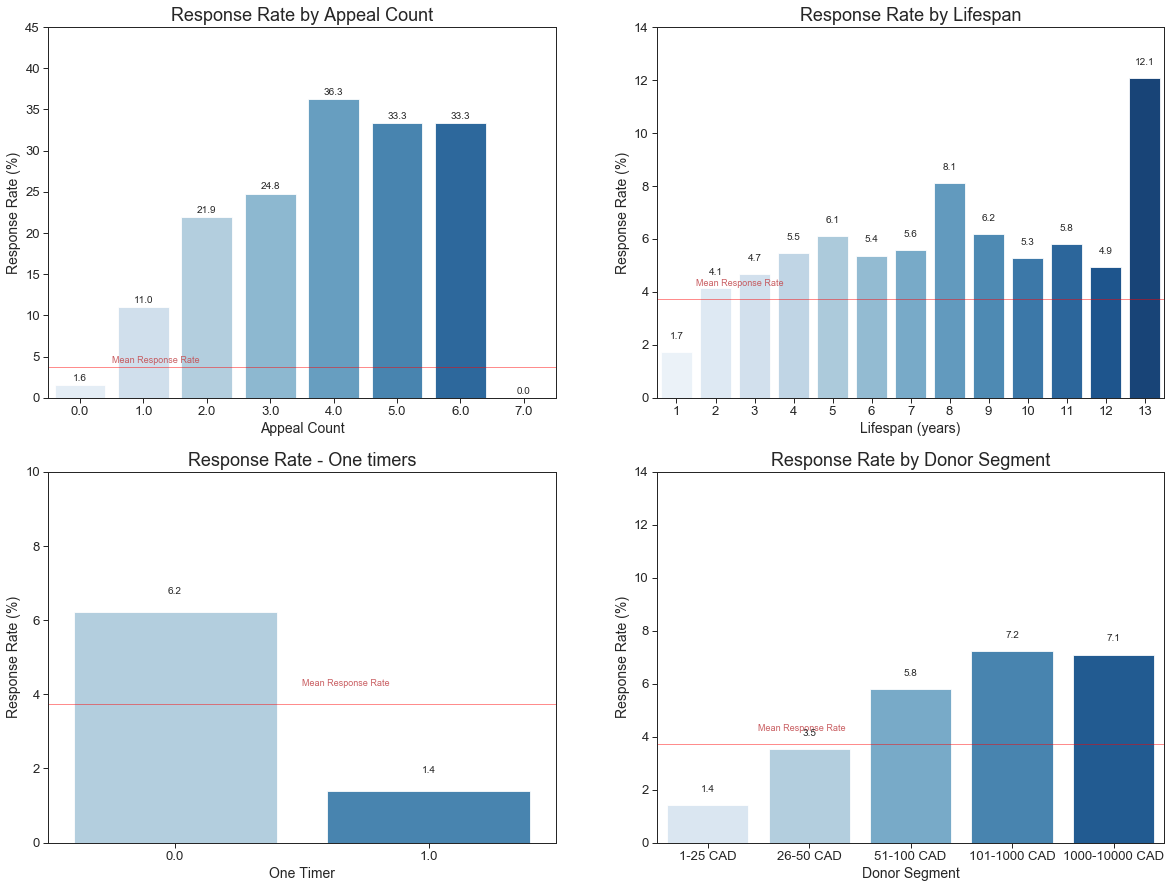

In [64]:
mean = df['Response_appeal'].mean()*100

plt.figure(figsize=(20,15))

    
plt.subplot(2,2,1)

ax = sns.barplot(x = 'appeal_count_MS', y = df['Response_appeal']*100 ,data = df, palette ="Blues",ci = None)
plt.axhline(y=mean, color = 'red',linewidth= 0.5, alpha= 0.9)
plt.xlabel('Appeal Count', fontsize=14)
plt.ylabel('Response Rate (%)', fontsize=14)
plt.xticks(rotation=0)
plt.yticks(np.arange(0,46, 5))
plt.title("Response Rate by Appeal Count", fontsize=18)
ax.text(0.5, mean + 0.5, "Mean Response Rate", fontsize=9, color ="r", alpha= 0.9)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.5,
            np.nan_to_num(np.round(height,1)),
            ha="center")
    
    
plt.subplot(2,2,2)

bins = pd.cut(df['lifespan_total_MS'], np.arange(0,5000,365) ,include_lowest=True, labels = np.arange(1,14,1))
table1 = df.groupby(bins)['Response_appeal'].agg(['mean','count']).reset_index()

ax = sns.barplot(x = 'lifespan_total_MS', y = table1['mean']*100 ,data = table1, palette ="Blues",ci = None)
plt.axhline(y = mean, color = 'red',linewidth= 0.5, alpha= 0.9)
plt.xlabel('Lifespan (years)', fontsize=14)
plt.ylabel('Response Rate (%)', fontsize=14)
plt.xticks(rotation= 0)
plt.yticks(np.arange(0, 16, 2))
plt.title("Response Rate by Lifespan", fontsize=18)
ax.text(0.5, mean + 0.5, "Mean Response Rate", fontsize=9, color ="r", alpha= 0.9)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.5,
            np.nan_to_num(np.round(height,1)),
            ha="center")
    
        
plt.subplot(2,2,3)

ax = sns.barplot(x = 'one_timer_MS', y = df['Response_appeal']*100 ,data = df, palette ="Blues",ci = None)
plt.axhline(y= mean, color = 'red',linewidth= 0.5, alpha= 0.9)
plt.xlabel('One Timer', fontsize=14)
plt.ylabel('Response Rate (%)', fontsize=14)
plt.xticks(rotation= 0)
plt.yticks(np.arange(0, 12, 2))
plt.title("Response Rate - One timers", fontsize=18)
ax.text(0.5, mean + 0.5, "Mean Response Rate", fontsize=9, color ="r", alpha= 0.9)


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.5,
            np.nan_to_num(np.round(height,1)),
            ha="center")

    
plt.subplot(2,2,4)


ax = sns.barplot(x = 'donation_segment_ave_MS', y = df['Response_appeal']*100 ,data = df, palette ="Blues",ci = None,
                 order = ['1-25 CAD', '26-50 CAD', '51-100 CAD', '101-1000 CAD','1000-10000 CAD'])

plt.axhline(y = mean, color = 'red',linewidth= 0.5, alpha= 0.9)
plt.xlabel('Donor Segment', fontsize=14)
plt.ylabel('Response Rate (%)', fontsize=14)
plt.xticks(rotation= 0)
plt.yticks(np.arange(0, 16, 2))
plt.title("Response Rate by Donor Segment", fontsize=18)
ax.text(0.5, mean + 0.5, "Mean Response Rate", fontsize=9, color ="r", alpha= 0.9)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.5,
            np.nan_to_num(np.round(height,1)),
            ha="center")

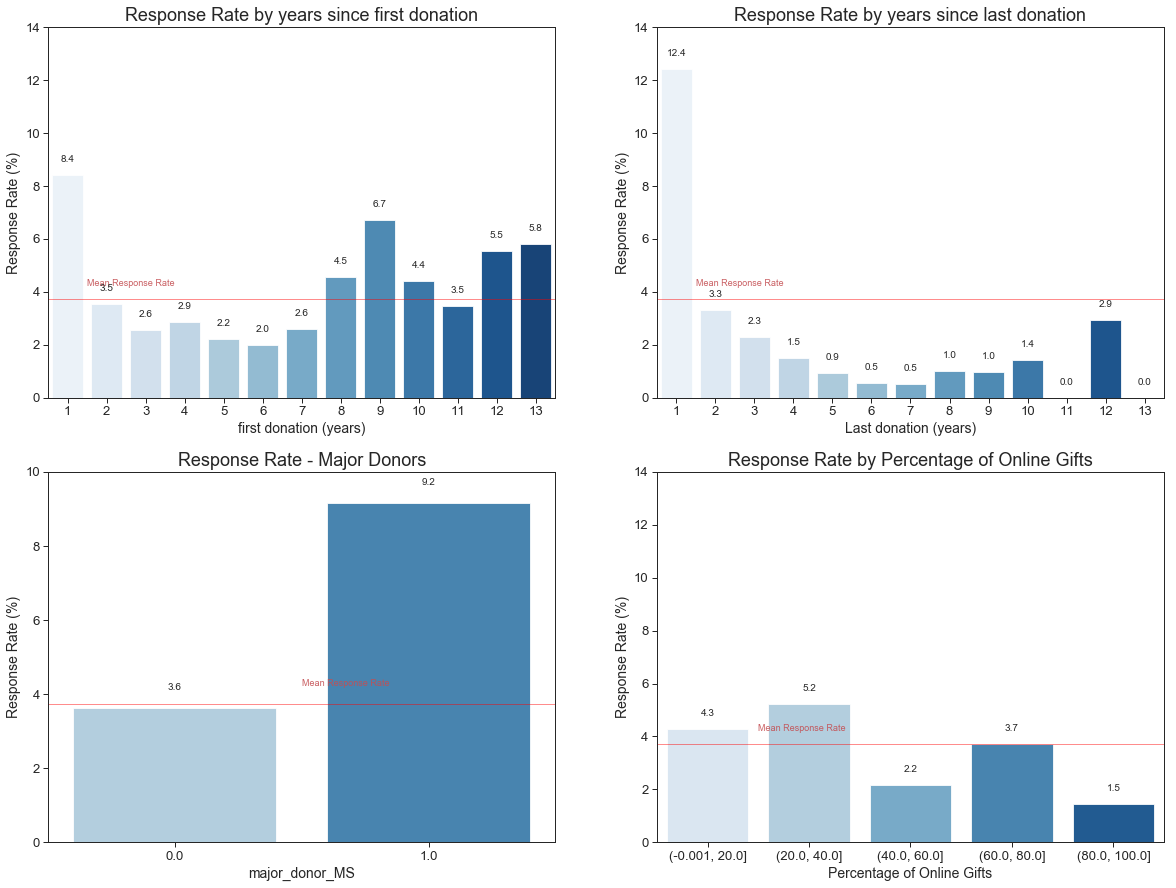

In [26]:
mean = df['Response_appeal'].mean()*100

plt.figure(figsize=(20,15))

plt.subplot(2,2,1)

bins = pd.cut(df['days_sfd_MS'], np.arange(0,5000,365) ,include_lowest=True, labels = np.arange(1,14,1))
table1 = df.groupby(bins)['Response_appeal'].agg(['mean','count']).reset_index()

ax = sns.barplot(x = 'days_sfd_MS', y = table1['mean']*100 ,data = table1, palette ="Blues",ci = None)
plt.axhline(y = mean, color = 'red',linewidth= 0.5, alpha= 0.9)
plt.xlabel('first donation (years)', fontsize=14)
plt.ylabel('Response Rate (%)', fontsize=14)
plt.xticks(rotation= 0)
plt.yticks(np.arange(0, 16, 2))
plt.title("Response Rate by years since first donation", fontsize=18)
ax.text(0.5, mean + 0.5, "Mean Response Rate", fontsize=9, color ="r", alpha= 0.9)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.5,
            np.nan_to_num(np.round(height,1)),
            ha="center")
    
    
plt.subplot(2,2,2)

bins = pd.cut(df['days_sld_MS'], np.arange(0,5000,365) ,include_lowest=True, labels = np.arange(1,14,1))
table1 = df.groupby(bins)['Response_appeal'].agg(['mean','count']).reset_index()

ax = sns.barplot(x = 'days_sld_MS', y = table1['mean']*100 ,data = table1, palette ="Blues",ci = None)
plt.axhline(y = mean, color = 'red',linewidth= 0.5, alpha= 0.9)
plt.xlabel('Last donation (years)', fontsize=14)
plt.ylabel('Response Rate (%)', fontsize=14)
plt.xticks(rotation= 0)
plt.yticks(np.arange(0, 16, 2))
plt.title("Response Rate by years since last donation", fontsize=18)
ax.text(0.5, mean + 0.5, "Mean Response Rate", fontsize=9, color ="r", alpha= 0.9)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.5,
            np.nan_to_num(np.round(height,1)),
            ha="center")
    
        
plt.subplot(2,2,3)

ax = sns.barplot(x = 'major_donor_MS', y = df['Response_appeal']*100 ,data = df, palette ="Blues",ci = None)
plt.axhline(y= mean, color = 'red',linewidth= 0.5, alpha= 0.9)
plt.xlabel('major_donor_MS', fontsize=14)
plt.ylabel('Response Rate (%)', fontsize=14)
plt.xticks(rotation= 0)
plt.yticks(np.arange(0, 12, 2))
plt.title("Response Rate - Major Donors", fontsize=18)
ax.text(0.5, mean + 0.5, "Mean Response Rate", fontsize=9, color ="r", alpha= 0.9)


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.5,
            np.nan_to_num(np.round(height,1)),
            ha="center")

    
plt.subplot(2,2,4)


bins = pd.cut(df['pct_ON'], np.arange(0,120,20) ,include_lowest=True)
table1 = df.groupby(bins)['Response_appeal'].agg(['mean','count']).reset_index()

ax = sns.barplot(x = 'pct_ON', y = table1['mean']*100 ,data = table1, palette ="Blues",ci = None)
plt.axhline(y = mean, color = 'red',linewidth= 0.5, alpha= 0.9)
plt.xlabel('Percentage of Online Gifts', fontsize=14)
plt.ylabel('Response Rate (%)', fontsize=14)
plt.xticks(rotation= 0)
plt.yticks(np.arange(0, 16, 2))
plt.title('Response Rate by Percentage of Online Gifts', fontsize=18)
ax.text(0.5, mean + 0.5, "Mean Response Rate", fontsize=9, color ="r", alpha= 0.9)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.5,
            np.nan_to_num(np.round(height,1)),
            ha="center")

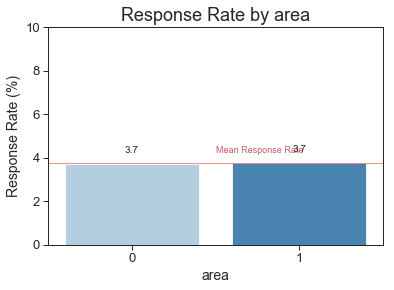

In [57]:
ax = sns.barplot(x = 'area', y = df['Response_appeal']*100 ,data = df, palette ="Blues",ci = None)
plt.axhline(y= mean, color = 'red',linewidth= 0.5, alpha= 0.9)
plt.xlabel('area', fontsize=14)
plt.ylabel('Response Rate (%)', fontsize=14)
plt.xticks(rotation= 0)
plt.yticks(np.arange(0, 12, 2))
plt.title("Response Rate by area", fontsize=18)
ax.text(0.5, mean + 0.5, "Mean Response Rate", fontsize=9, color ="r", alpha= 0.9)


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            np.nan_to_num(height) + 0.5,
            np.nan_to_num(np.round(height,1)),
            ha="center")

<font color='darkblue'>
    
- One can note that the ‘appeal count’ has great effect on the response rate. This is expected as it means how many times a donor has responded to direct mailing appeals in the past.  
  
  
- Other variables display some effect. Although the response rate varies in a much lesser extent when plotted against these. We can then assume that we have a lot of weak variables in terms of explanation, so a Machine Learning model would be a great way to combine all of these features and extract the most of it.

## 3.2 Correlations

<font color='darkblue'>
Below is displayed a table containing all variable pairs with correlation (Pearson) greater than 80%. Multicollinearity can  impact model performance and therefore should be avoided

In [ ]:
data = X_train.select_dtypes(include=['float64','int64'])
data = data.fillna(0)

In [29]:
s = data.corr().abs().unstack()
so = s.sort_values(kind="quicksort", ascending = False)

df_corr = pd.DataFrame(so).reset_index()
df_corr.columns =['var1', 'var2', 'corr']
df_corr[(df_corr['corr'] > 0.80) & (df_corr['var1'] != df_corr['var2'])].drop_duplicates('corr')

,var1,var2,corr
134,appeal_count,appeal_count_MS,1.000000
211,last_gift_year_GWV,first_gift_year_GWV,0.999999
213,first_gift_year_ERSG,last_gift_year_ERSG,0.999998
215,last_gift_year_MS,first_gift_year_MS,0.999920
217,days_sfd,first_gift_year,0.994746
219,average_donated_ERSG,median_donated_ERSG,0.992421
221,average_donated_GWV,median_donated_GWV,0.985579
223,average_donated_MS,median_donated_MS,0.982686
225,ave_donation_gap_ERSG,donation_rate_ERSG,0.982109
227,days_sld,last_gift_year,0.979627


<font color='darkblue'>
    
- Note that there are 163 pairs of highly correlated variables. This high number was already expected because all these features were engineered from only a few initial features from a transactions database. Still a reasonable amount of non-linear correlated features was left.  

    
- An attempt was made of removing these correlated features manually before fedding the model, but better results were obtained by letting the Pipeline algorithm pick the most important features for training.  

# 4. Machine Learning

<font color='darkblue'>
    
- The binary response variable is called 'response_appeal'. 1 if for responsive donors and 0 for unresponsive. It is worth mentioning that classes are very imbalanced as the proportion of ones represent approximately 3.8% of the total observations.


- We are starting with a total of 174 features for prediction. There will be a future selection step to select the most relevant ones.


- Three models will be trained and tested against the benchmark model (current process od creating mailing lists): Logistic Regression, Random Forest Classifier and Support Vector Classifier. They are set up to return the probability instead of the label class. The threshold will be defined by a user defined function that calculates the profit per unit (Donor). This will be discussed in more detail below.


- Pipelines were built for inputting missing values, one hot encoding, normalizing, feature selection and predicting. Finally, a randomized grid search will be executed for hyperparameter tuning.


- Models are going to be assessed based on their precision and recall curves and most importantly on the profit per unit.  


In [59]:
df = pd.read_csv('ML datasets/appeals_ETA_dataset.csv')
df.drop('Unnamed: 0', axis = 1 , inplace = True)

## 4.1 Split training and test datasets

<font color='darkblue'>
The size of test split chosen is 30%.  

In [61]:
X = df.drop('Response_appeal', axis = 1)
y = df['Response_appeal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 42)

In [62]:
X_train.info(verbose =True, max_cols= 300)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13429 entries, 16026 to 15795
Data columns (total 174 columns):
Donor_ID                     13429 non-null object
appeal_count_MS              13103 non-null float64
ave_donation_gap_MS          13103 non-null float64
average_donated_MS           13103 non-null float64
donation_count_MS            13103 non-null float64
donation_count_ON_MS         13103 non-null float64
first_gift_amount_MS         13103 non-null float64
first_gift_date_MS           13103 non-null object
last_gift_amount_MS          13103 non-null float64
last_gift_date_MS            13103 non-null object
max_donated_MS               13103 non-null float64
max_donation_gap_MS          13103 non-null float64
median_donated_MS            13103 non-null float64
min_donation_gap_MS          13103 non-null float64
total_donated_MS             13103 non-null float64
total_donated_ON_MS          13103 non-null float64
lifespan_total_MS            13103 non-null float64
one_t

## 4.2 Feature selection

<font color='darkblue'>
    
Two feature selection techniques were tested:  
    
    
    
- Filter based by calculating the scores of ANOVA tests between the response (categorical variable) and independent variables (mostly continuous variables). 


- Wrapper Based using the Recursive Feature Selection (RFE) technique with Random Forest as an estimator.

The results (not shown) reveals that the RFE is more suitable for this problem. It should be able to remove irrelevant variables and highly correlated ones since they do not add variance to the model.


<font color='darkblue'>
The code below displays the 20 most important variables by each technique.

In [ ]:
cat_features = ['province']
num_features = list(X_train.select_dtypes(include=[np.number]).columns)

In [46]:
## Name of all features tested

ohe = OneHotEncoder()
ohe.fit(df[cat_features].fillna('ON'))
ohe_names = list(ohe.get_feature_names())

feature_names = num_features + ohe_names

In [47]:
# Filter Based - Select K best (f_classifier)

X_train_prep = prep_pipeline.fit_transform(X_train)
y_train_prep = y_train

selector = SelectKBest(score_func = f_classif, k=20)

selector.fit(X_train_prep, y_train_prep)

cols = selector.get_support(indices=True)

[feature_names[i] for i in cols]

['appeal_count_MS',
 'donation_count_MS',
 'max_donation_gap_MS',
 'total_donated_MS',
 'lifespan_total_MS',
 'one_timer_MS',
 'major_donor_MS',
 'donation_rate_MS',
 'days_sld_MS',
 'days_sfd_MS',
 '2016_MS',
 '2018_MS',
 'Apr_MS',
 'Jun_MS',
 'Dec_MS',
 'active_year_MS',
 'currently_active_MS',
 'currently_active_GWV',
 'active_year_ERSG',
 'pct_ON']

In [48]:
# Wrapper Based - Recursive feature elimination 

X_train_prep = prep_pipeline.fit_transform(X_train)
y_train_prep = y_train

estimator = RandomForestClassifier(random_state=42)
selector = RFE(estimator, 20, step=1)

selector.fit(X_train_prep, y_train_prep)

col2 = selector.get_support(indices=True)

[feature_names[i] for i in col2]

['appeal_count_MS',
 'ave_donation_gap_MS',
 'average_donated_MS',
 'first_gift_amount_MS',
 'max_donation_gap_MS',
 'median_donated_MS',
 'min_donation_gap_MS',
 'total_donated_MS',
 'lifespan_total_MS',
 'donation_rate_MS',
 'days_sld_MS',
 'days_sfd_MS',
 '2018_MS',
 'Apr_MS',
 'Dec_MS',
 'days_sfd_GWV',
 'days_sld_ERSG',
 'days_sfd_ERSG',
 'pct_MS',
 'pct_ERSG']

## 4.3 Pipelines

### 4.3.1 Preparation  Pipeline

<font color='darkblue'>
Codes for the preparation Pipeline. Responsible for inputting missing values, one hot enconding and normalizing

In [45]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'constant')),
    ('std_scaler', StandardScaler())   
    ])


cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('one_hot_encod',OneHotEncoder())
    ])


# Preparation pipeline
prep_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])


### 4.3.2 ML pipelines

<font color='darkblue'>
The ML Pipelines connects the Preparation Pipelines with the feature selection process and the model. There is a total of three complete Pipelines, one for each model 

In [ ]:
# Logistic Regression Classifier pipeline with RFE

estimator = RandomForestClassifier(random_state=42)
rfe = RFE(estimator, step=2)


logreg = LogisticRegression(random_state=42)


full_pipeline_logreg = Pipeline([
        ("preparation", prep_pipeline),
        ('feature_selection', rfe),
        ("logreg_model", logreg)
    ])


# Random Forest classifier pipeline with RFE

estimator = RandomForestClassifier(random_state=42)
rfe = RFE(estimator, step=2)


rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')


full_pipeline_rf = Pipeline([
        ("preparation", prep_pipeline),
        ('feature_selection', rfe),
        ("rf_model", rf)
    ])


# Support Vector Classifier pipeline with RFE

estimator = RandomForestClassifier(random_state=42)

rfe = RFE(estimator, step=2)


svc = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state = 42)


full_pipeline_svc = Pipeline([
        ("preparation", prep_pipeline),
        ('feature_selection', rfe),
        ("svc_model", svc)
    ])

## 4.4 Cost function

<font color='darkblue'>
    
The cost function was defined by the user based on the cost in Dollars of True Positives, False Positives, True Negatives and False Negatives since they are know. So, based on the outcome of the model, for a given threshold, we are able to calculate the profit from all the donors that are being tested.

**True Positives (Predicting correctly a responsive donor) = + 180 CAD (average gift amount expected from donors)** 

**True Negatives (Predicting correctly an unresponsive donor) = + 2 CAD (No money is being spent on unresponsive mailing)**

**False Positives (Classifying a responsive donor as unresponsive) = - 180 CAD (Money not gained)**

**False Negative (Classifying an unresponsive donor as responsive) = - 2 CAD (Mail spent on unresponsive donors)**


 - Since the cost and gains from TP, TN , FP and FN are know we can maximize the total profit of the test set by optimizing the threshold for each model.


- Since the average gift amount is relatively high we expect to have a model with a high recall.


- The model that returns the higher profit per unit on the test set should be the one to be considered.


In [55]:
# This is the cost function to determine the right probability threshold of the model. It considers business aspect of the campaing

def class_converter (y_pred, thre):
    
    v_range = np.arange(0,len(y_pred[:,1]),1)
    y_pred_class = [1 if y_pred[i,1] >= thre else 0 for i in v_range ]
    
    return y_pred_class
    

def campaign_profit(y_pred, y_test, thre):
    
    mail_cost = 2
    ave_gift = 180
    
    y_pred_class = class_converter (y_pred, thre)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
      
    return (tn*mail_cost - fn*(ave_gift - mail_cost) - fp*mail_cost + tp*(ave_gift - mail_cost))/len(y_pred)
    


def profit_optimizer (y_pred, y_test, step, max_values = True):
    profit = []
    threshold = []
    
    for j in np.arange(0,1,step):
    
        threshold.append(j)
        profit.append(campaign_profit(y_pred, y_test,j))
    
    if max_values == True:
        return (np.max(profit), threshold[np.argmax(profit)])
    
    else:
        return [profit, threshold]
    
    

def response_rate(tp,fn, fp):
    
    return tp/(tp + fn+ fp)*100

## 4.5 Plot Functions for Model Assessment

<font color='darkblue'>
These are functions to plot precision and recall curves, ROC curves and the user defined cost function

In [56]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12, 12))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.xticks(np.arange(0, 1, step=0.05))
    plt.yticks(np.arange(0, 1, step=0.05))
    
    plt.xlim([0, 1])
    plt.show()
    
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.title('Precision Vs Recall', fontsize=14)
    
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=14)
    

def unitary_profit_curve (threshold, profit, y_pred, y_test):
    
    plt.figure(figsize=(9, 9))
    plt.plot(threshold, profit, "b-", linewidth=2)
    plt.ylabel("Profit per unit ($)", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.title('Profit per unit VS Threshold', fontsize=14)
    #plt.xticks(np.arange(0, 1, 0.1))
    #plt.yticks(np.arange(-6, 6.5, 0.5))

    profit, thre = profit_optimizer(y_pred, y_test, 0.001)

    plt.axvline(x = thre , color = 'red',linewidth= 0.5, alpha= 0.9)

    plt.show()

## 4.6 Model training

<font color='darkblue'>

This section demonstrates how the models are trained. Randomized Grid Search is used for tunig hyperparameters and the optimum number of features.  


    
After each model has been optimized it was saved using the Pickle package

### 4.6.1 Benchmark Model

<font color='darkblue'>
The Benchmark model represents the current process of creating direct mailing lists. Since the organization sends mail to everyone, it the same as classifying every donor as responsive.

In [25]:
# This is the current model. It classifies every donor as a responder.

def bench_model (X_test):
    
    pred_0 = [[x] for x in list(np.zeros(len(X_test)))]
    pred_1 = [[x] for x in list(np.ones(len(X_test)))]

    return np.array([x + y for x, y in zip(pred_0, pred_1)])
    

### 4.6.2 Logistic Regression 

In [ ]:
param_grid_logreg = {'logreg_model__C': [10**-2, 10**-1, 10**0, 10**1, 10**2],'feature_selection__n_features_to_select' :np.arange(5,146,5),
                    'logreg_model__penalty': ['l1','l2']}

logreg_rand_search = RandomizedSearchCV(full_pipeline_logreg, param_grid_logreg, cv=5, n_iter=4,
                           scoring = 'neg_log_loss')

logreg_rand_search.fit(X_train, y_train)

In [58]:
logreg_rand_search = pickle.load(open('logreg_model_optimized.sav', 'rb'))

In [59]:
logreg_rand_search.best_params_

{'logreg_model__penalty': 'l1',
 'logreg_model__C': 0.1,
 'feature_selection__n_features_to_select': 125}

In [60]:
logreg_rand_search.best_score_

-0.4599070116534431

In [61]:
y_pred_logreg = cross_val_predict(logreg_rand_search.best_estimator_, X_train, y_train, cv=10, method='predict_proba')

### 4.6.3 Random Forest Classifier

In [ ]:
param_grid_rf = {'rf_model__max_depth': np.arange(2,100,5) ,'rf_model__min_samples_split': np.arange(5,100,5),
                 'rf_model__max_features' : [None,'auto'], 'feature_selection__n_features_to_select' :np.arange(5,146,5)}

rf_rand_search = RandomizedSearchCV(full_pipeline_rf, param_grid_rf, cv=5, n_iter=300,
                           scoring = 'neg_log_loss')

rf_rand_search.fit(X_train, y_train)

In [32]:
rf_rand_search = pickle.load(open('rf_model_optimized.sav', 'rb'))

In [33]:
rf_rand_search.best_params_

{'rf_model__min_samples_split': 15,
 'rf_model__max_features': 'auto',
 'rf_model__max_depth': 47,
 'feature_selection__n_features_to_select': 75}

In [34]:
rf_rand_search.best_score_

-0.17709074583862

In [35]:
y_pred_rf = cross_val_predict(rf_rand_search.best_estimator_, X_train, y_train, cv=10, method='predict_proba')

### 4.6.4 Support Vector Classifier

In [ ]:
param_rand_svc = {'svc_model__gamma' :[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ],'svc_model__C' : [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ],
                  'svc_model__degree' :[2, 3, 4, 5], 'feature_selection__n_features_to_select' :np.arange(5,146,5)}

svc_rand_search =  RandomizedSearchCV(full_pipeline_svc, param_rand_svc, cv=5, n_iter = 200, scoring = 'neg_log_loss')

svc_rand_search.fit(X_train, y_train)

In [36]:
svc_rand_search = pickle.load(open('svc_model_optimized.sav', 'rb'))

In [37]:
svc_rand_search.best_params_

{'svc_model__gamma': 0.01,
 'svc_model__degree': 4,
 'svc_model__C': 0.1,
 'feature_selection__n_features_to_select': 15}

In [38]:
svc_rand_search.best_score_

-0.12744218944379193

In [39]:
y_pred_svc = cross_val_predict(svc_rand_search.best_estimator_, X_train, y_train, cv=10, method='predict_proba')

# 5. Model Assessment

<font color='darkblue'>
    
This section displays the plots for each model for assessment. The curves were calculated by using 10 fold cross validation in the training set.

## 5.1 Metrics Plots

### 5.1.1 Logistic Regression 

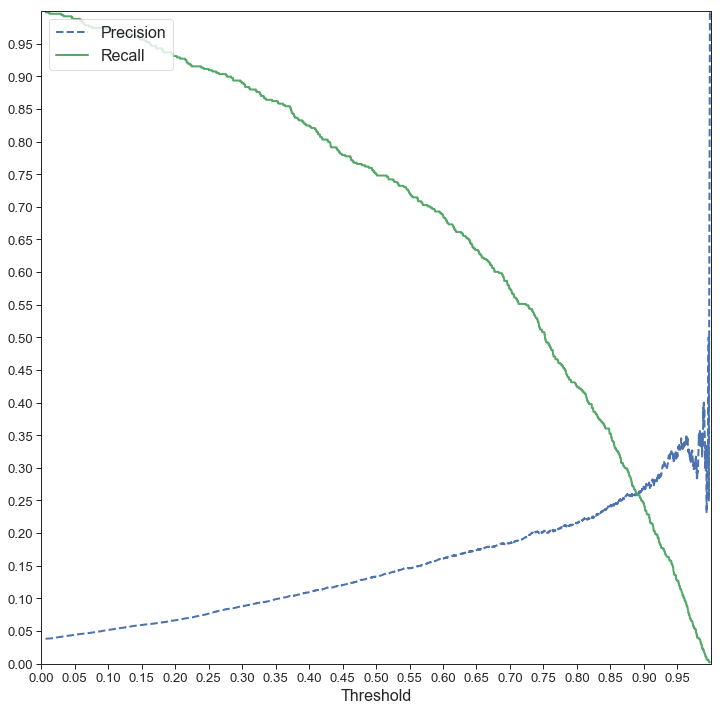

In [62]:
precisions, recalls, thresholds = precision_recall_curve(y_train, probas_pred= y_pred_logreg[:,1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

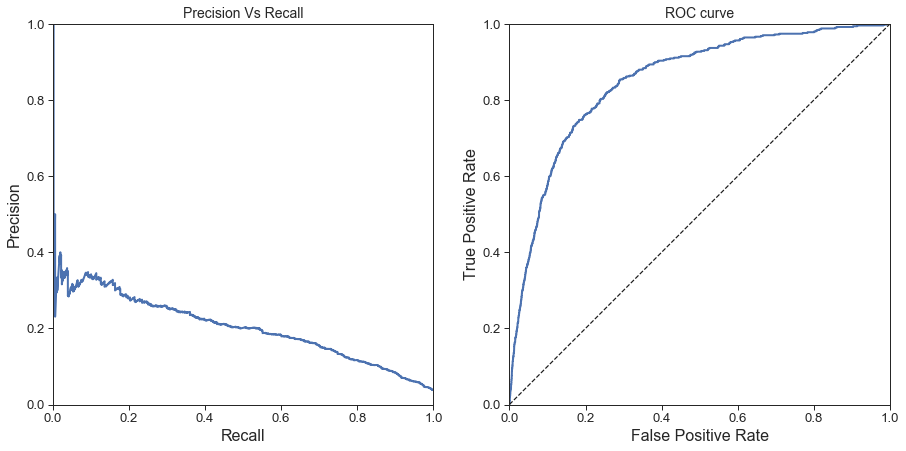

In [63]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_logreg[:,1])
    
plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)
plot_precision_vs_recall(precisions, recalls)


plt.subplot(1,2,2)
plot_roc_curve(fpr, tpr)

plt.show()

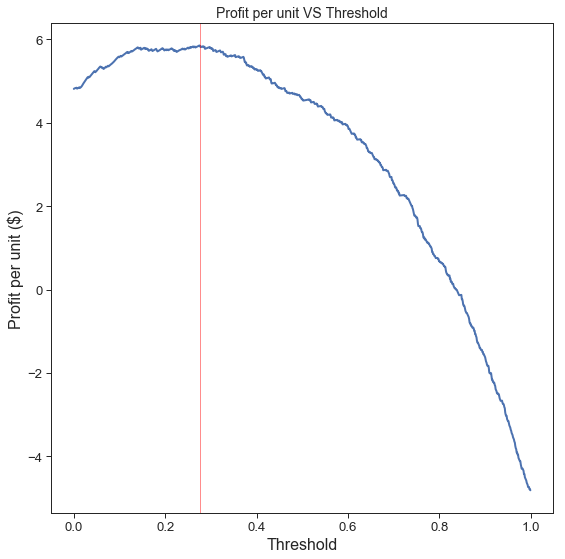

In [64]:
v = profit_optimizer(y_pred_logreg, y_train, 0.001, False)
unitary_profit_curve (v[1], v[0], y_pred_logreg, y_train) 

In [65]:
logreg_profit, logreg_thre = profit_optimizer(y_pred_logreg, y_train, 0.001)
logreg_profit, logreg_thre

(5.848983543078412, 0.275)

### 5.1.2 Random Forest Classifier 

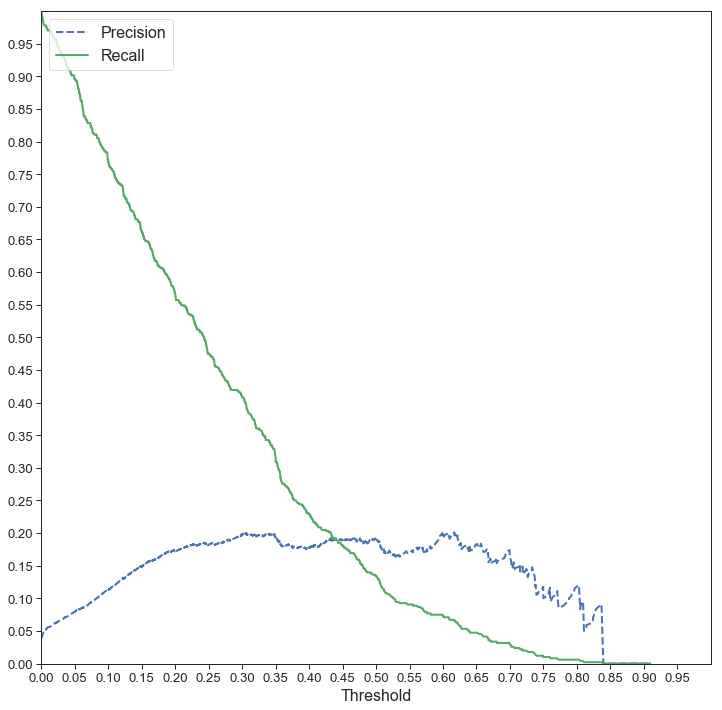

In [45]:
precisions, recalls, thresholds = precision_recall_curve(y_train, probas_pred= y_pred_rf[:,1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

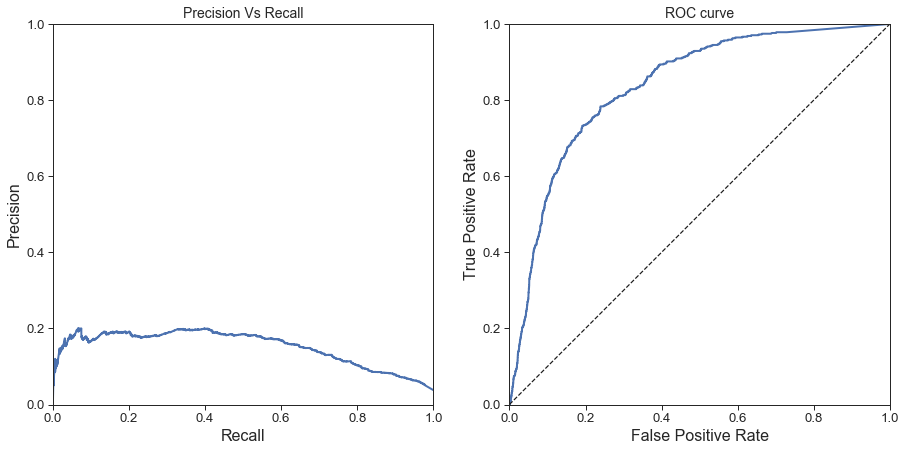

In [46]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_rf[:,1])
    
plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)
plot_precision_vs_recall(precisions, recalls)


plt.subplot(1,2,2)
plot_roc_curve(fpr, tpr)

plt.show()

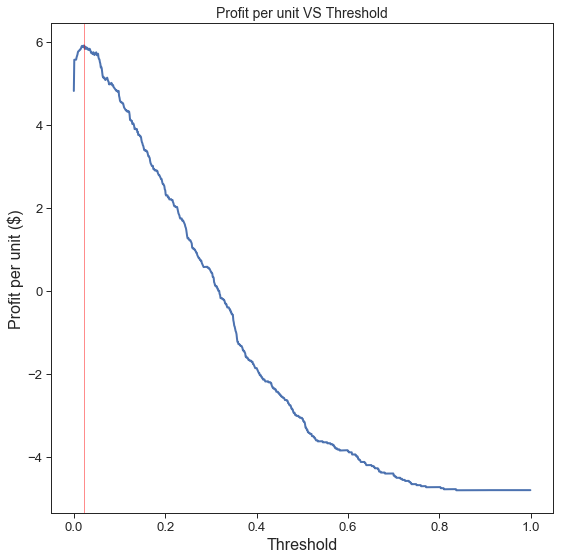

In [47]:
v = profit_optimizer(y_pred_rf, y_train, 0.001, False)
unitary_profit_curve (v[1], v[0], y_pred_rf, y_train) 

In [48]:
rf_profit, rf_thre = profit_optimizer(y_pred_rf, y_train, 0.001)
rf_profit, rf_thre

(5.904386030233078, 0.022)

### 5.1.3 Support Vector Classifier

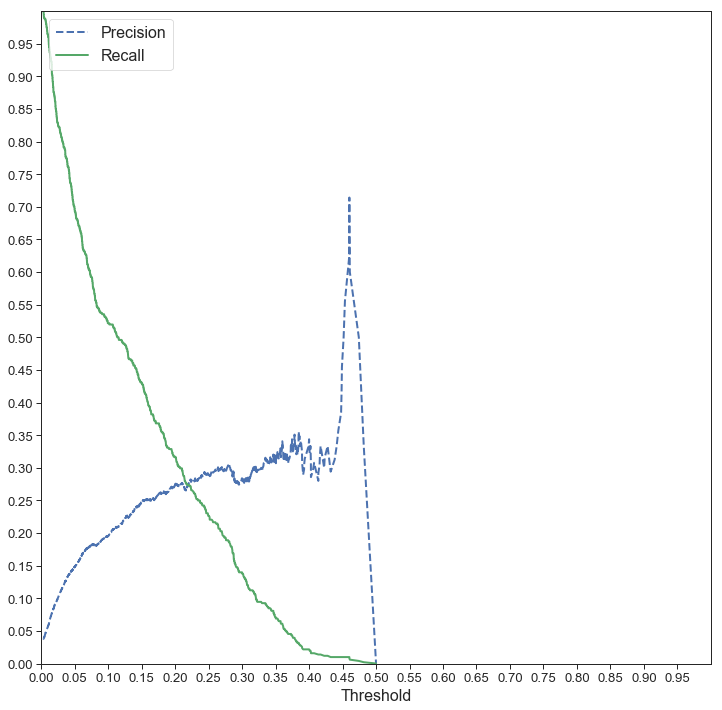

In [49]:
precisions, recalls, thresholds = precision_recall_curve(y_train, probas_pred= y_pred_svc[:,1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

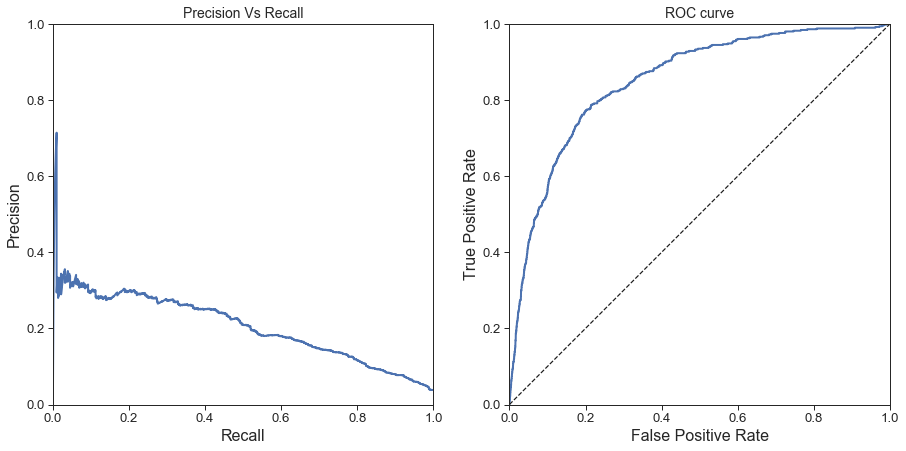

In [50]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_svc[:,1])
    
plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)
plot_precision_vs_recall(precisions, recalls)


plt.subplot(1,2,2)
plot_roc_curve(fpr, tpr)

plt.show()

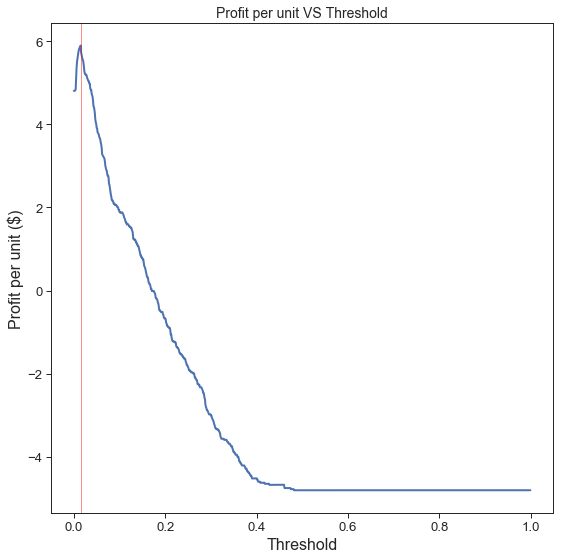

In [51]:
v = profit_optimizer(y_pred_svc, y_train, 0.001, False)
unitary_profit_curve (v[1], v[0], y_pred_svc, y_train)

In [52]:
svc_profit, svc_thre = profit_optimizer(y_pred_svc, y_train, 0.001)
svc_profit, svc_thre

(5.900811676223099, 0.015)

<font color='darkblue'>

The profit per unit obtained for each of the models were the following (10 fold cross validation):

- Logistic Regression - 5.848 CAD/donor (Optimum Threshold = 27.5%)

- Random Forest - 5.904 CAD/donor (Optimum Threshold = 2.2%)

- Support Vector Classifier - 5.901 CAD/donor (Optimum Threshold = 1.5%)


## 5.2 Tests Scores

<font color='darkblue'>
The final section provides the test scores for each model

### 5.2.1 Benchmark Model

In [54]:
y_pred_bm_class = bench_model (X_test)
campaign_profit(y_pred_bm_class, y_test, 1)

4.504517025712301

In [55]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bm_class[:,1]).ravel()

print(confusion_matrix(y_test, y_pred_bm_class[:,1]))
print(classification_report(y_test, y_pred_bm_class[:,1]))

[[   0 5548]
 [   0  208]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5548
           1       0.04      1.00      0.07       208

   micro avg       0.04      0.04      0.04      5756
   macro avg       0.02      0.50      0.03      5756
weighted avg       0.00      0.04      0.00      5756



In [57]:
tp/(tp + fn + fp)*100

3.6136205698401667

### 5.2.2 Logistic Regression

In [66]:
y_pred_logreg = logreg_rand_search.predict_proba(X_test)
campaign_profit(y_pred_logreg, y_test, logreg_thre)

5.4586518415566365

In [67]:
y_pred_logreg_class = class_converter(y_pred_logreg,logreg_thre )

print(confusion_matrix(y_test, y_pred_logreg_class))
print(classification_report(y_test, y_pred_logreg_class))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_logreg_class).ravel()

[[3331 2217]
 [  22  186]]
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      5548
           1       0.08      0.89      0.14       208

   micro avg       0.61      0.61      0.61      5756
   macro avg       0.54      0.75      0.45      5756
weighted avg       0.96      0.61      0.73      5756



In [68]:
tp/(tp + fn+ fp)*100

7.6701030927835046

### 5.2.3 Random Forest

In [96]:
y_pred_rf = rf_rand_search.predict_proba(X_test)
campaign_profit(y_pred_rf, y_test, rf_thre)

5.343988881167477

In [97]:
y_pred_rf_class = class_converter(y_pred_rf,rf_thre )

print(confusion_matrix(y_test, y_pred_rf_class))
print(classification_report(y_test, y_pred_rf_class))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf_class).ravel()

[[2365 3183]
 [  13  195]]
              precision    recall  f1-score   support

           0       0.99      0.43      0.60      5548
           1       0.06      0.94      0.11       208

   micro avg       0.44      0.44      0.44      5756
   macro avg       0.53      0.68      0.35      5756
weighted avg       0.96      0.44      0.58      5756



In [98]:
tp/(tp + fn+ fp)*100

5.750516071955176

### 5.2.4 Support Vector Classifier

In [99]:
y_pred_svc = svc_rand_search.predict_proba(X_test)
campaign_profit(y_pred_svc, y_test, svc_thre)

5.496177901320362

In [100]:
y_pred_svc_class = class_converter(y_pred_svc, svc_thre)

print(confusion_matrix(y_test, y_pred_svc_class))
print(classification_report(y_test, y_pred_svc_class))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svc_class).ravel()

[[3029 2519]
 [  18  190]]
              precision    recall  f1-score   support

           0       0.99      0.55      0.70      5548
           1       0.07      0.91      0.13       208

   micro avg       0.56      0.56      0.56      5756
   macro avg       0.53      0.73      0.42      5756
weighted avg       0.96      0.56      0.68      5756



In [101]:
tp/(tp + fn+ fp)*100

6.967363403006967

<font color='darkblue'>
    
The profit per unit obtained for each of the models in the test set were:

- Benchmark model - Unitary profit = 4.50 CAD/Donor , response rate = 3.61 %


- Logistic Regression - 5.46 CAD/donor , response rate = 7.67 %


- Random Forest - 5.34 CAD/donor , response rate = 5.75 %


- Support Vector Classifier - 5.49 CAD/donor , response rate = 6.98 %


# 6. Conclusion

<font color='darkblue'>
    
- The Support Vector Classifier displayed the best performance with a profit per unit of 5.49 CAD followed by the logistic regression. Note that all models surpassed the benchmark model.


- One  important observation though is that in general all models performed relatively poor, as shown by the precision and recall percentages. The SVC, for instance, displayed precision and recall at the operation point equal to 6.9% and 91% respectively.  The main reason for this behavior is that we have high biased models due to features which are not  capable of fully explaining the behavior of donor response. Recall that the 174 features available are highly correlated and, therefore, do not bring a lot of variance to the model. 


- Example of extra features that could be added to the model to increase its performance include :
Age
Gender
Family size
Educational level
Household income
Occupation
Motivation
Interaction with donors
Demographic information


- Nevertheless, even though little information was available to train a model, the results show that  Machine Learning along with data engineering have a great potential to increase gains in fundraising. **The Support Vector Classifier was able to increase revenues in 22% and doubling the response rate when compared to the current process of selecting donors**.


- The next step will involve testing the model in production. This will be a crucial test to verify other types of bias the model may be subjected to and also find ways to improve its performance. This means that the benchmark model will still be running as the main process for some time.
